# Stack Overflow Case Study- By Himani Attri

Importing Libraries

Installing boto3- we need to install it in collab firstly

In [1]:
!pip install boto3

In [2]:
import pandas as pd
import boto3
import s3transfer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import datetime
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import math
import re
from collections import Counter

warnings.filterwarnings('ignore')



## Reading Data from S3 buckets

In [3]:
qsns_url='https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Questions.csv'

ansrs_url='https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Answers.csv'

tags_url='https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Tags.csv'

users_url='https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Users.csv'

In [4]:
qsns=pd.read_csv(qsns_url,encoding='iso-8859-1')

ansrs=pd.read_csv(ansrs_url,encoding='iso-8859-1')

tags=pd.read_csv(tags_url,encoding='iso-8859-1')

users=pd.read_csv(users_url,encoding='iso-8859-1')

In [6]:
# Checking the shape of files
print(qsns.shape, ansrs.shape, tags.shape, users.shape)

(1264216, 7) (2014516, 6) (3750994, 2) (1990480, 9)


## 1. Starting with EDA of qsns file- 


*   Head, info, describe
*   Renaming certain column names for better understanding
*   Checking for missing values, Removing duplicates
*   Correcting date time formats







Will get basic idea of how content & columns look like in qsns data

In [7]:
# Checking first few lines from data
qsns.head()

Id  ...                                               Body
0   80  ...  <p>I've written a database generation script i...
1   90  ...  <p>Are there any really good tutorials explain...
2  120  ...  <p>Has anyone got experience creating <strong>...
3  180  ...  <p>This is something I've pseudo-solved many t...
4  260  ...  <p>I have a little game written in C#. It uses...

[5 rows x 7 columns]

In [8]:
# Checking the non null content of columns in data
qsns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [9]:
# Checking missing values explicitly
qsns.isnull().sum()

Id                    0
OwnerUserId       14454
CreationDate          0
ClosedDate      1208257
Score                 0
Title                 0
Body                  0
dtype: int64

From above results, we can see that there are nulls in OwnerUserId & ClosedDate column
A qsn can be closed due to N reasons- like duplicate qsn or wrong one- So no issues with missing in this column, will be do our analysis only on qsns that were never closed. [As those are correct qsns to do the analysis]

Renaming few columns for better clarity

In [10]:
# Renaming few columns for better clarity
qsns.rename(columns={"Id": "qsn_id", "Score": "qsn_score","OwnerUserId":'Qsn_by_user_id','CreationDate':'qsn_creation_date','ClosedDate':'qsn_closed_date','Title':'qsn_title','Body':'qsn_body'},inplace=True)
qsns.head()


qsn_id  ...                                           qsn_body
0      80  ...  <p>I've written a database generation script i...
1      90  ...  <p>Are there any really good tutorials explain...
2     120  ...  <p>Has anyone got experience creating <strong>...
3     180  ...  <p>This is something I've pseudo-solved many t...
4     260  ...  <p>I have a little game written in C#. It uses...

[5 rows x 7 columns]

Checking for duplicates in the data

In [11]:
# Checking whether each row is a unique qsn or not
print(qsns.shape,len(qsns['qsn_id'].unique()))


(1264216, 7) 1264216


In [12]:
# There are no duplicates in the data, however performing a quick remove_duplicates to validate the same
qsns.drop_duplicates(inplace=True)
print(qsns.shape)

(1264216, 7)


Standardizing Qsn Score & Creation Date from qsns data

In [13]:
print(qsns['qsn_score'].min(),qsns['qsn_score'].max())

-73 5190


In [14]:
qsns['qsn_score'].quantile([0,0.25,0.5,0.7,0.9,0.95,0.99,1])
# It seems skewed " presence of outliers"

0.00     -73.0
0.25       0.0
0.50       0.0
0.70       1.0
0.90       4.0
0.95       6.0
0.99      22.0
1.00    5190.0
Name: qsn_score, dtype: float64

Box Plot to understand better- Appears column is suffering from outlier problem

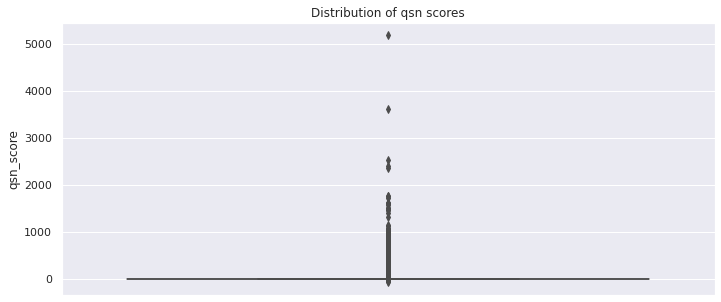

In [15]:
sns.set(rc={'figure.figsize':(11.7,5)})
ax = sns.boxplot(y="qsn_score", data=qsns)
plt.title('Distribution of qsn scores')
plt.show()

We can see the distribution has lot of outliers

Outlier Treatment for Qsn Score column

In [16]:
# Replacing any value > 99% percentile by 99% value and < 1% percentile by 1%  value

qsns['qsn_score']=np.where( qsns['qsn_score'] > qsns['qsn_score'].quantile(0.99),  qsns['qsn_score'].quantile(0.99),
                           np.where( qsns['qsn_score'] < qsns['qsn_score'].quantile(0.01), qsns['qsn_score'].quantile(0.01),
                                    qsns['qsn_score'])
                           )


In [17]:
qsns['qsn_score'].quantile([0,0.25,0.5,0.7,0.9,0.95,0.99,1])

0.00    -3.0
0.25     0.0
0.50     0.0
0.70     1.0
0.90     4.0
0.95     6.0
0.99    22.0
1.00    22.0
Name: qsn_score, dtype: float64

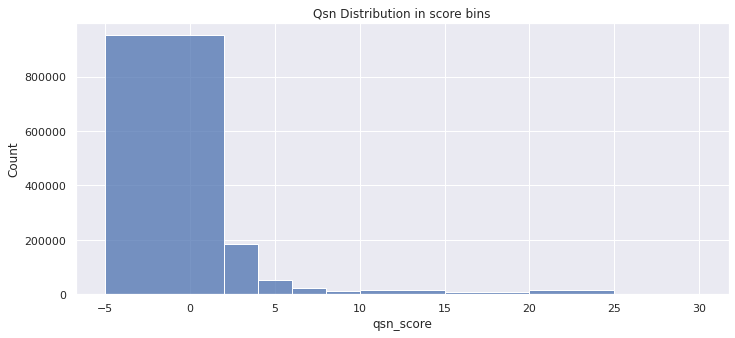

In [18]:
# We can see the qsns distribution in score bins using below histogram

sns.set(rc={'figure.figsize':(11.7,5)})
sns.histplot(data=qsns, x="qsn_score",bins=[-5,2,4,6,8,10,15,20,25,30])
plt.title('Qsn Distribution in score bins')
plt.show()

From above plot, we can see majority of qsns fall in low score category

Dealing with Qsn Creation Date Format- as it is given in a different format with offset zero which is UTC time stamp only. So changing it in correct date format so that we can perform our analysis smoothly using it. 

In [19]:
# Converting qsn_creation_date & qsn_closed_date into right format

date_format = "%Y-%m-%dT%H:%M:%SZ" 
qsns['qsn_creation_date']=qsns['qsn_creation_date'].apply(lambda x: datetime.strptime(x, date_format))
qsns['qsn_creation_date']=pd.to_datetime(qsns['qsn_creation_date'],format='%Y-%m-%d %H:%M:%S')
qsns['qsn_creation_date'].head()


0   2008-08-01 13:57:07
1   2008-08-01 14:41:24
2   2008-08-01 15:50:08
3   2008-08-01 18:42:19
4   2008-08-01 23:22:08
Name: qsn_creation_date, dtype: datetime64[ns]

In [20]:
qsns.dtypes

qsn_id                        int64
Qsn_by_user_id              float64
qsn_creation_date    datetime64[ns]
qsn_closed_date              object
qsn_score                   float64
qsn_title                    object
qsn_body                     object
dtype: object

This is how our refined Qsns Data look like.

In [21]:
qsns.head()

qsn_id  ...                                           qsn_body
0      80  ...  <p>I've written a database generation script i...
1      90  ...  <p>Are there any really good tutorials explain...
2     120  ...  <p>Has anyone got experience creating <strong>...
3     180  ...  <p>This is something I've pseudo-solved many t...
4     260  ...  <p>I have a little game written in C#. It uses...

[5 rows x 7 columns]

## 2. Exploring & Standardizing Tags Data set
*   Head, info, describe
*   Renaming certain column names for better understanding
*   Checking for missing values, Removing duplicates
*   Bringing multiple lines of tags in one line by collating
*   Identifying Data Science Tags from them
*   Making Indicators of Data Science Tags presence 




Will start with basic EDA on the data set to see how data looks like

In [22]:
tags.head()

Id             Tag
0  80            flex
1  80  actionscript-3
2  80             air
3  90             svn
4  90     tortoisesvn

In [23]:
# Renaming few columns for better understanding
tags.rename(columns={"Id": "qsn_id"},inplace=True)
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   qsn_id  int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


Checking for duplicates in data

In [24]:
print(tags.shape,len(tags['qsn_id'].unique()))

(3750994, 2) 1264216


In [25]:
print(tags.shape)

tags.drop_duplicates(inplace=True)

print(tags.shape)


(3750994, 2)
(3750993, 2)


Removed one duplicate entry from the data and checking for nulls in the tags


In [26]:
tags.isnull().sum()

qsn_id       0
Tag       1112
dtype: int64

In [27]:
# dropping blank tags lines
print(len(tags['qsn_id'].unique()))

tags.dropna(inplace=True)


print(len(tags['qsn_id'].unique()))
print(tags.isnull().sum())

# This shows 2 qsns ID's didn't have any tags corresponding to them. 
# Hence its fine to drop blanks as in rest 1110, with some blank tag there were other tags were marked

1264216
1264214
qsn_id    0
Tag       0
dtype: int64


In [28]:
len(list(tags['Tag'].unique()))

37034

A rough investigation on how the data science tags (python, r, sas, excel, matlab, excel, sql) are present in the data. This will help in understanding whether we need to use the contains or exact match of tags.

In [29]:
print(list(tags[tags['Tag'].str.lower().str.contains('sql')]['Tag'].unique()))
print(list(tags[tags['Tag'].str.lower()=='sql']['Tag'].unique()))
print(tags[tags['Tag'].str.lower().str.contains('sql')]['Tag'].value_counts())

print(list(tags[tags['Tag'].str.lower().str.contains('matlab')]['Tag'].unique()))
print(list(tags[tags['Tag'].str.lower()=='matlab']['Tag'].unique()))
print(tags[tags['Tag'].str.lower().str.contains('matlab')]['Tag'].value_counts())

print(list(tags[tags['Tag'].str.lower().str.contains('sas')]['Tag'].unique()))
print(list(tags[tags['Tag'].str.lower()=='sas']['Tag'].unique()))
print(tags[tags['Tag'].str.lower().str.contains('sas')]['Tag'].value_counts())

print(list(tags[tags['Tag'].str.lower().str.contains('excel')]['Tag'].unique()))
print(list(tags[tags['Tag'].str.lower()=='excel']['Tag'].unique()))
print(tags[tags['Tag'].str.lower().str.contains('excel')]['Tag'].value_counts())

print(list(tags[tags['Tag'].str.lower().str.contains('python')]['Tag'].unique()))
print(list(tags[tags['Tag'].str.lower()=='python']['Tag'].unique()))
print(tags[tags['Tag'].str.lower().str.contains('python')]['Tag'].value_counts())

# There are tags which are relatively similar to sql, matlab, ssas, excel, python.
# We are not taking them into consideration and doing exact match with sql, python, matlab, excel.
# There is no clear instruction on whether these need to be part of data science tag or not.


['sql', 'sql-server', 'sql-server-2005', 'sql-server-2008', 'postgresql', 'mysql', 'tsql', 'sqlite', 'linq-to-sql', 'sql-server-2000', 'mysql-error-1062', 'mysql-management', 'sql-server-ce', 'sql-injection', 'sql-server-mobile', 'sqlclr', 'sql-server-express', 'mysql-error-2006', 'plsql', 'sqlanywhere', 'sqlplus', 'sqlprofiler', 'sql-execution-plan', 'sql-server-2005-express', 'dynamic-sql', 'plpgsql', 'mysqli', 'sqlparameter', 'sqlbulkcopy', 'sql-update', 'mysql-error-1093', 'sql-scripts', 'hsqldb', 'sql-server-2008-r2', 'sqlconnection.close', 'sql-order-by', 'sql-server-profiler', 'sql-server-2012', 'sqlalchemy', 'sqldatareader', 'sql-server-agent', 'mysql-error-1242', 'sqlcommand', 'tsqlt', 'ansi-sql', 'sql-like', 'sql-data-services', 'sql-server-data-services', 'sqlparameters', 'sqldbtype', 'sqlite3', 'sql-server-7', 'sqlconnection', 'sqlbindparameter', 'sqldatasource', 'mysql-proxy', 'sql-in', 'system.data.sqlite', 'oracle-sqldeveloper', 'mysqlimport', 'sql-drop', 'sql-server-adm

There are tags which are relatively similar to sql, matlab, ssas, excel, python.
We are not taking them into consideration and doing exact match with sql, python, matlab, excel.
There is no clear instruction on whether these need to be part of data science tag or not.


Proceeding with Data Science Tags Tagging

In [30]:
# If tags is any of 'python', 'r', 'matlab', 'sas', 'excel', 'sql' then it is a data science tag

list_of_data_science_tags=['python', 'r', 'matlab', 'sas', 'excel', 'sql']

tags['Data_Science_Tag_or_Other']=np.where(tags['Tag'].str.lower().str.strip().isin(list_of_data_science_tags), 'Data_Science_Tag',np.where(tags['Tag'].isnull(),'No Tag','Other_Tag'))
tags['Data_Science_Tag_or_Other'].value_counts()

Other_Tag           3616221
Data_Science_Tag     133660
Name: Data_Science_Tag_or_Other, dtype: int64

Checking the distribution of qsns over the tags, a qsn can consists of multiple tags in it 

In [31]:
tags[tags['Data_Science_Tag_or_Other']=='Data_Science_Tag']['Tag'].value_counts(normalize=True)

python    0.483323
sql       0.267709
r         0.117470
excel     0.077690
matlab    0.048593
sas       0.005215
Name: Tag, dtype: float64

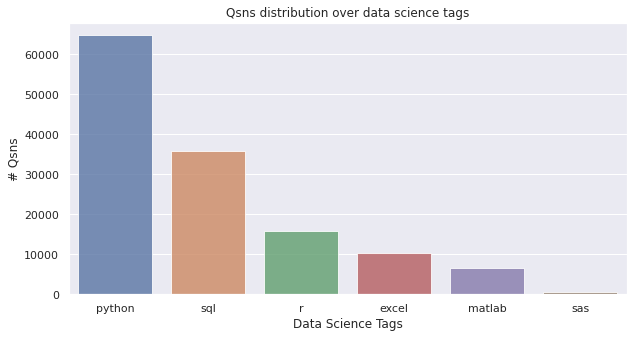

In [32]:
datascience_tags_count  = tags[tags['Data_Science_Tag_or_Other']=='Data_Science_Tag']['Tag'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(datascience_tags_count.index, datascience_tags_count.values, alpha=0.8)
plt.title('Qsns distribution over data science tags')
plt.xlabel('Data Science Tags')
plt.ylabel('# Qsns')
plt.show()

From above graph, we can see python tag appears in majority 48% of the qsns, then SQL in 26 % of the qsns and list goes on in order python>sql>r>excel>matlab>sas

In [33]:
tags.head()

qsn_id             Tag Data_Science_Tag_or_Other
0      80            flex                 Other_Tag
1      80  actionscript-3                 Other_Tag
2      80             air                 Other_Tag
3      90             svn                 Other_Tag
4      90     tortoisesvn                 Other_Tag

Here we can see, a qsn id has multiple tags associated, bringing them at same level so that a qsn id has only one line in this data. It will make more sense in our further analysis

In [34]:
# Grouping tags
tags_grouped=tags.sort_values(['qsn_id','Tag']).groupby(['qsn_id'],as_index=False)['Tag'].apply(','.join)
tags_grouped.columns=['qsn_id','Tag_grouped']
tags_grouped.head()



qsn_id                                     Tag_grouped
0      80                         actionscript-3,air,flex
1      90    branch,branching-and-merging,svn,tortoisesvn
2     120                             asp.net,sitemap,sql
3     180  algorithm,color-space,colors,language-agnostic
4     260         .net,c#,compiler-construction,scripting

In [35]:
# Grouping Tag_Types, it will show whether only data science tag was present or it was present in combination with any other tag or it was not at all present

type_tags_grouped=tags[['qsn_id','Data_Science_Tag_or_Other']].sort_values(['qsn_id','Data_Science_Tag_or_Other']).drop_duplicates().groupby(['qsn_id'],as_index=False)['Data_Science_Tag_or_Other'].apply(','.join)
type_tags_grouped.columns=['qsn_id','Tag_Type_grouped']
type_tags_grouped.head()


qsn_id            Tag_Type_grouped
0      80                   Other_Tag
1      90                   Other_Tag
2     120  Data_Science_Tag,Other_Tag
3     180                   Other_Tag
4     260                   Other_Tag

In [36]:
tag_data_refined=pd.merge(tags_grouped,type_tags_grouped, on='qsn_id',how='left')
tag_data_refined.head()

qsn_id  ...            Tag_Type_grouped
0      80  ...                   Other_Tag
1      90  ...                   Other_Tag
2     120  ...  Data_Science_Tag,Other_Tag
3     180  ...                   Other_Tag
4     260  ...                   Other_Tag

[5 rows x 3 columns]

Trying to visualize the distribution of tags

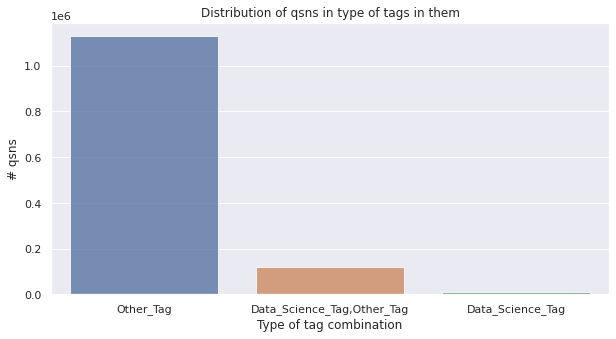

In [37]:
type_count  = tag_data_refined['Tag_Type_grouped'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(type_count.index, type_count.values, alpha=0.8)
plt.title('Distribution of qsns in type of tags in them')
plt.ylabel('# qsns')
plt.xlabel('Type of tag combination')
plt.show()

We can see from above that majority of qsns doesn't involve data science tags

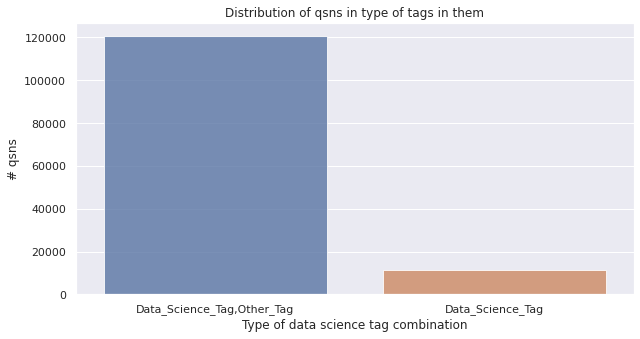

In [38]:
# How data science tag presence looks like 

DS_type_count  = tag_data_refined[tag_data_refined['Tag_Type_grouped'].isin(['Data_Science_Tag','Data_Science_Tag,Other_Tag'])]['Tag_Type_grouped'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(DS_type_count.index, DS_type_count.values, alpha=0.8)
plt.title('Distribution of qsns in type of tags in them')
plt.ylabel('# qsns')
plt.xlabel('Type of data science tag combination')
plt.show()

We can see from above that when data science tags come up, they come up in combination with non data science tags majority of the time

Creating individual indicators of python, r, matlab, sas, excel, sql presence in qsn


In [39]:
def tag_presence(tag):
  list_of_qsns=list(tags[tags['Tag']==tag]['qsn_id'].unique())
  tag_data_refined[tag+'_presence']=np.where(tag_data_refined['qsn_id'].isin(list_of_qsns), 'Yes','No')
  return tag_data_refined
  

In [40]:
tag_data_refined=tag_presence(tag='python')
tag_data_refined=tag_presence(tag='r')
tag_data_refined=tag_presence(tag='matlab')
tag_data_refined=tag_presence(tag='sas')
tag_data_refined=tag_presence(tag='excel')
tag_data_refined=tag_presence(tag='sql')

In [41]:
print(tag_data_refined['python_presence'].value_counts())
print(tag_data_refined['r_presence'].value_counts())
print(tag_data_refined['matlab_presence'].value_counts())
print(tag_data_refined['sas_presence'].value_counts())
print(tag_data_refined['excel_presence'].value_counts())
print(tag_data_refined['sql_presence'].value_counts())

No     1199613
Yes      64601
Name: python_presence, dtype: int64
No     1248513
Yes      15701
Name: r_presence, dtype: int64
No     1257719
Yes       6495
Name: matlab_presence, dtype: int64
No     1263517
Yes        697
Name: sas_presence, dtype: int64
No     1253830
Yes      10384
Name: excel_presence, dtype: int64
No     1228432
Yes      35782
Name: sql_presence, dtype: int64


Mapping no. of tags per qsn present in data

In [42]:
tags_per_qsn_count=tags.groupby(['qsn_id'],as_index=False).agg({'Tag':'count'})
tags_per_qsn_count.columns=['qsn_id','no. of tags present']

tag_data_refined=pd.merge(tag_data_refined,tags_per_qsn_count, on ='qsn_id',how='left')



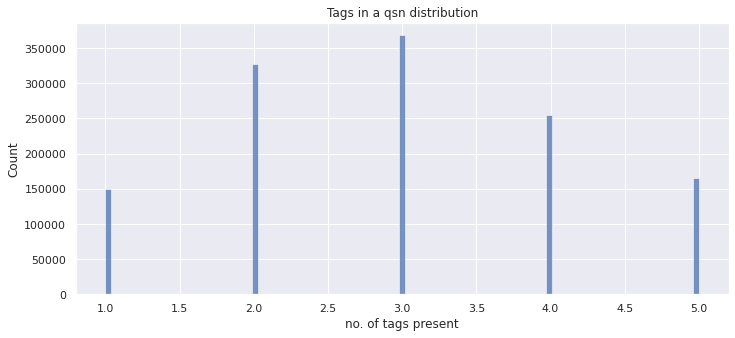

In [43]:
# Distribution of qsns over tags
sns.set(rc={'figure.figsize':(11.7,5)})
sns.histplot(data=tag_data_refined, x="no. of tags present")
plt.title('Tags in a qsn distribution')
plt.show()

We can see from above, that majority qsn comes with 2 or 3 tags on them. 

This is how our refined tags data looks like. Will be using it for our further analysis.

In [44]:
tag_data_refined.head()

qsn_id  ... no. of tags present
0      80  ...                   3
1      90  ...                   4
2     120  ...                   3
3     180  ...                   4
4     260  ...                   4

[5 rows x 10 columns]

## 3. Exploring Users Data set
*   Head, info, describe
*   Renaming certain column names for better understanding
*   Checking for missing values, Removing duplicates
*   Corecting the date formats


In [45]:
users.head()

Unnamed: 0  id display_name  ... up_votes down_votes  views
0           0  26        Shawn  ...      565         67   3547
1           1  26        Shawn  ...      565         67   3547
2           2  26        Shawn  ...      565         67   3547
3           3  26        Shawn  ...      565         67   3547
4           4  26        Shawn  ...      565         67   3547

[5 rows x 9 columns]

In [46]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990480 entries, 0 to 1990479
Data columns (total 9 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Unnamed: 0        int64 
 1   id                int64 
 2   display_name      object
 3   creation_date     object
 4   last_access_date  object
 5   reputation        int64 
 6   up_votes          int64 
 7   down_votes        int64 
 8   views             int64 
dtypes: int64(6), object(3)
memory usage: 136.7+ MB


Renaming columns for better undertanding &  removing duplicates 

In [47]:
# Renaming columns properly for better undertanding
users.drop(['Unnamed: 0'],inplace=True,axis=1)
users.rename(columns={"id": "user_id","creation_date":'user_account_creation_date',"up_votes":'user_up_votes','down_votes':'user_down_votes','views':'user_profile_views','reputation':'user_reputation','display_name':'user_display_name','last_access_date':'user_account_access_last_date'},inplace=True)
users.head()


user_id user_display_name  ... user_down_votes user_profile_views
0       26             Shawn  ...              67               3547
1       26             Shawn  ...              67               3547
2       26             Shawn  ...              67               3547
3       26             Shawn  ...              67               3547
4       26             Shawn  ...              67               3547

[5 rows x 8 columns]

In [48]:
print(users.shape,len(users['user_id'].unique()))

(1990480, 8) 465460


In [49]:
# Dropping duplicates 
users.drop_duplicates(inplace=True)
print(users.shape,len(users['user_id'].unique()))


# Now we have equal lines to that of users we have in the data

(465460, 8) 465460


In [50]:
users.isnull().sum()
# user_display name is null in few entries, but we can let them be

user_id                           0
user_display_name                24
user_account_creation_date        0
user_account_access_last_date     0
user_reputation                   0
user_up_votes                     0
user_down_votes                   0
user_profile_views                0
dtype: int64

Analyzing User Reputation field to get better understanding

In [51]:
users['user_reputation'].quantile([0,0.25,0.5,0.7,0.9,0.95,0.99,1])

0.00          1.00
0.25         66.00
0.50        353.00
0.70        886.00
0.90       3495.00
0.95       6914.00
0.99      27381.64
1.00    1128126.00
Name: user_reputation, dtype: float64

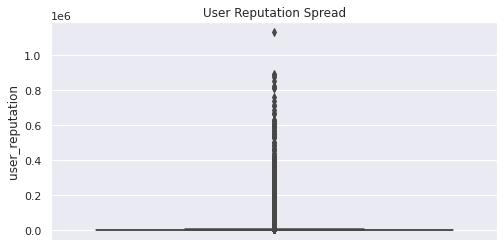

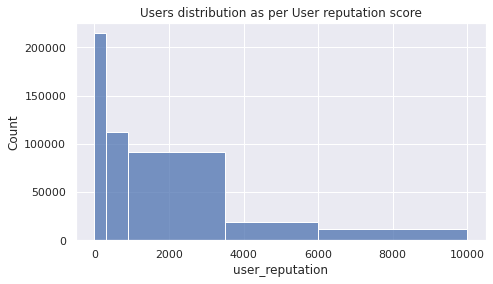

In [52]:
plt.figure(figsize=(8, 4))

plt.title('User Reputation Spread')
sns.boxplot(y=users.user_reputation, palette=("cubehelix"))
plt.show()


plt.figure(figsize=(25, 4))
plt.subplot(1,3,2)
plt.title('Users distribution as per User reputation score')
sns.histplot(data=users, x="user_reputation", bins=[0,300,900,3500, 6000,10000])
plt.show()


User reputation seems skewed too, but it is possible, depending on the no. of ansrs and quality of answers users give. Will not be treating it as it will help me finding top users 


Checking correlation between reputation, downvote, upvote and profile views

In [53]:
# checking correlation will give us some idea over how they are related with each other

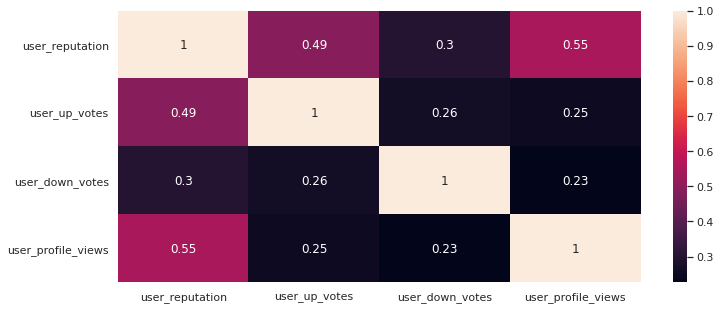

In [54]:
rating = users[['user_reputation','user_up_votes','user_down_votes','user_profile_views']]

corrMatrix = rating.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

From above, we didn't see high correlation, but user reputation seems significantly corelated with profile views and user up votes

Correcting date formats so that they can be worked with smoothly

In [55]:
# Correcting date formats

def convert_date(x):
  try:
    date_format = "%Y-%m-%d %H:%M:%S UTC" 
    y=datetime.strptime(x, date_format)
  except:
    date_format = "%Y-%m-%d %H:%M:%S.%f UTC" 
    y=datetime.strptime(x, date_format)
  return y



users['user_account_creation_date']=users['user_account_creation_date'].apply(lambda x: convert_date(x))
users['user_account_creation_date']=pd.to_datetime(users['user_account_creation_date'],format='%Y-%m-%d %H:%M:%S')

users['user_account_access_last_date']=users['user_account_access_last_date'].apply(lambda x: convert_date(x))
users['user_account_access_last_date']=pd.to_datetime(users['user_account_access_last_date'],format='%Y-%m-%d %H:%M:%S')

users.head()


user_id user_display_name  ... user_down_votes user_profile_views
0        26             Shawn  ...              67               3547
27     1109              Theo  ...             136               6905
85   364174             stats  ...               1                 60
87       61           Bernard  ...             219               1731
97    20709       Black Horus  ...               2                 96

[5 rows x 8 columns]

## 4. Exploring Ansrs Data set
*   Head, info, describe
*   Renaming certain column names for better understanding
*   Checking for missing values, Removing duplicates
*   Corecting the date formats


Will get an understanding over how data looks like

In [56]:
ansrs.head()

Id  OwnerUserId  ... Score                                               Body
0   92         61.0  ...    13  <p><a href="http://svnbook.red-bean.com/">Vers...
1  124         26.0  ...    12  <p>I wound up using this. It is a kind of a ha...
2  199         50.0  ...     1  <p>I've read somewhere the human eye can't dis...
3  269         91.0  ...     4  <p>Yes, I thought about that, but I soon figur...
4  307         49.0  ...    28  <p><a href="http://www.codeproject.com/Article...

[5 rows x 6 columns]

Renaming columns for better understanding and removing duplicates

In [57]:
# renaming columns
ansrs.rename(columns={"Id": "ansr_id","CreationDate":'ansr_creation_date',"ParentId":'qsn_id','Score':'ansr_score','Body':'ansr_body','OwnerUserId':'ansr_by_user_id'},inplace=True)
ansrs.head()

ansr_id  ...                                          ansr_body
0       92  ...  <p><a href="http://svnbook.red-bean.com/">Vers...
1      124  ...  <p>I wound up using this. It is a kind of a ha...
2      199  ...  <p>I've read somewhere the human eye can't dis...
3      269  ...  <p>Yes, I thought about that, but I soon figur...
4      307  ...  <p><a href="http://www.codeproject.com/Article...

[5 rows x 6 columns]

In [58]:
print(ansrs.shape,len(ansrs['ansr_id'].unique()), len(ansrs['qsn_id'].unique()))

# Sames lines as that of no. of ansrs id hence no duplicates
# Also, a qsn can have more than one ansr

# Validating
ansrs.drop_duplicates(inplace=True)

print(ansrs.shape,len(ansrs['ansr_id'].unique()), len(ansrs['qsn_id'].unique()))

(2014516, 6) 2014516 1102568
(2014516, 6) 2014516 1102568


Correcting date format 

In [59]:
# Correcting date format
date_format = "%Y-%m-%dT%H:%M:%SZ" 
ansrs['ansr_creation_date']=ansrs['ansr_creation_date'].apply(lambda x: datetime.strptime(x, date_format))
ansrs['ansr_creation_date']=pd.to_datetime(ansrs['ansr_creation_date'],format='%Y-%m-%d %H:%M:%S')
ansrs['ansr_creation_date'].head()


0   2008-08-01 14:45:37
1   2008-08-01 16:09:47
2   2008-08-01 19:36:46
3   2008-08-01 23:49:57
4   2008-08-02 01:49:46
Name: ansr_creation_date, dtype: datetime64[ns]

This is how final refined ansrs data set looks like

In [60]:
ansrs.head()

ansr_id  ...                                          ansr_body
0       92  ...  <p><a href="http://svnbook.red-bean.com/">Vers...
1      124  ...  <p>I wound up using this. It is a kind of a ha...
2      199  ...  <p>I've read somewhere the human eye can't dis...
3      269  ...  <p>Yes, I thought about that, but I soon figur...
4      307  ...  <p><a href="http://www.codeproject.com/Article...

[5 rows x 6 columns]

## Ready to bring data on to same page for further analysis


* Will only consider the qsns that were never closed for our analysis
* Adding tags to qns (qsns that were not closed)
* Adding ansrs to qsns
* Adding users who answered to qsns


In [61]:
# Merging the above refined data sets
# Adding tags to qns (qsns that were not closed)
# Adding ansrs to qsns
# Adding users who answered to qsns


qsns_not_closed=qsns[qsns['qsn_closed_date'].isnull()]

final_data=pd.merge(pd.merge(pd.merge(qsns_not_closed,tag_data_refined, left_on='qsn_id',right_on='qsn_id',how='left'), 
                    ansrs, left_on='qsn_id',right_on='qsn_id', how='left'),
                    users, left_on='ansr_by_user_id',right_on='user_id',how='left')

final_data.shape



(2068509, 29)

Dropping qsn closed date field as it is useless for us now, as we have considered only the qsns that were never closed i.e. blanks in qsn closed field

In [62]:

final_data.drop(['qsn_closed_date'],axis=1,inplace=True)
final_data.head()

qsn_id  Qsn_by_user_id  ... user_down_votes  user_profile_views
0      80            26.0  ...            67.0              3547.0
1      80            26.0  ...           136.0              6905.0
2      80            26.0  ...             1.0                60.0
3     120            83.0  ...             0.0               105.0
4     180       2089740.0  ...            50.0              1731.0

[5 rows x 28 columns]

A qsn can have multiple answers, so there would be more lines in the data than the asked no. of qsns

In [63]:
print(final_data.shape,len(final_data['qsn_id'].unique()))

(2068509, 28) 1208257


## Objective-2
Starting with objective 2

When a user provides a data science tag ('python', 'r', 'matlab', 'sas', 'excel', 'sql') to their question, then Stack Overflow should come up with the expected approximate time to get it answered.

Filtering data for any Data Science Specific Tag instance -- leaving only Other Tag Category out

In [64]:
# Filtering data for any Data Science Specific Tag instance -- leaving only Other Tag Category out

final_data_data_science_tag_involvement=final_data[final_data['Tag_Type_grouped'].isin(['Data_Science_Tag','Data_Science_Tag,Other_Tag'])]
final_data_data_science_tag_involvement['Data_Science_Tag']='Yes'
print(final_data_data_science_tag_involvement.shape,len(final_data_data_science_tag_involvement['qsn_id'].unique()))

(218761, 29) 125110


A qsn can have multiple answers so mapping qsn to the first time it got answered out of many answers to find expected time taken to ansr


In [65]:
# A qsn can have multiple answers so mapping qsn to the first time it got answered out of many answers to find expected time taken to ansr
# Picking minimum ansr creation date per qsn, it will give us the time when the qsn was first time answered

Time_to_ansr=final_data_data_science_tag_involvement[['qsn_id','Tag_grouped','Tag_Type_grouped','qsn_creation_date','ansr_creation_date','Data_Science_Tag',
                                                      'python_presence','r_presence','matlab_presence','sas_presence','excel_presence','sql_presence']].drop_duplicates().groupby(
    ['qsn_id','Tag_grouped','Tag_Type_grouped','qsn_creation_date','Data_Science_Tag',
    'python_presence','r_presence','matlab_presence','sas_presence','excel_presence','sql_presence'],as_index=False).agg({"ansr_creation_date":'min'})
Time_to_ansr.head()

Time_to_ansr.rename(columns={'ansr_creation_date':'first_ansr_creation_date'},inplace=True)

# Extracting year too, I guess it will be helpful in our analysis 
Time_to_ansr['qsn_year']= Time_to_ansr['qsn_creation_date'].dt.year
Time_to_ansr.head()




qsn_id  ... qsn_year
0     120  ...     2008
1    1970  ...     2008
2    2120  ...     2008
3    2840  ...     2008
4    6340  ...     2008

[5 rows x 13 columns]

In [66]:
print(Time_to_ansr.shape, len(Time_to_ansr['qsn_id'].unique()))

(125110, 13) 125110


Time delta between qsn created & ansr created date

In [67]:
from datetime import datetime
Time_to_ansr['time_in_minutes']=((Time_to_ansr['first_ansr_creation_date']-Time_to_ansr['qsn_creation_date']).dt.seconds)/60

Time_to_ansr['time_in_hours']=((Time_to_ansr['first_ansr_creation_date']-Time_to_ansr['qsn_creation_date']).dt.seconds)/(60*60)

Time_to_ansr.head()

qsn_id  ... time_in_hours
0     120  ...      6.850833
1    1970  ...      0.066389
2    2120  ...      2.625000
3    2840  ...      0.039167
4    6340  ...      0.178333

[5 rows x 15 columns]

### At an overall data science tag tagged qsns, will see how we can provide the estimated time to answer a qsn

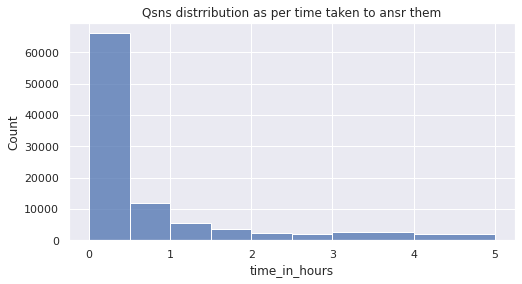

<Figure size 1800x288 with 0 Axes>

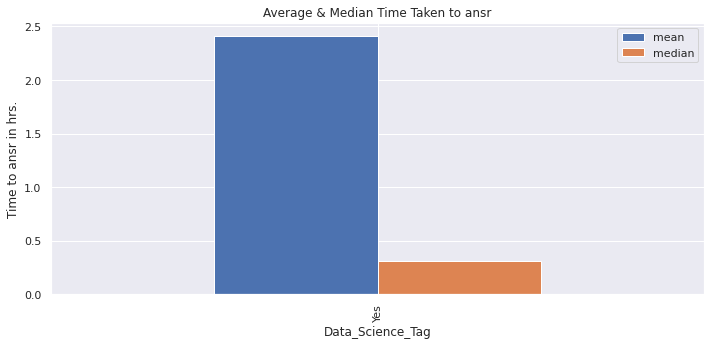

<Figure size 1800x288 with 0 Axes>

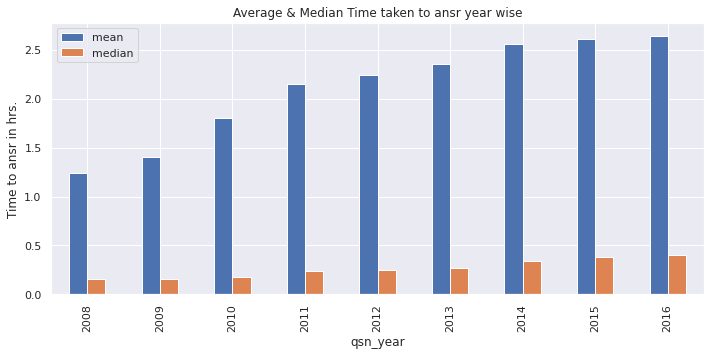

In [68]:
plt.figure(figsize=(8, 4));
plt.title('Qsns distrribution as per time taken to ansr them')
sns.histplot(data=Time_to_ansr, x="time_in_hours", bins=[0,0.5,1,1.5,2,2.5,3,4,5])
plt.show()

plt.figure(figsize=(25, 4));
Time_to_ansr.groupby('Data_Science_Tag')['time_in_hours'].agg(['mean','median']).plot.bar();
plt.title('Average & Median Time Taken to ansr')
plt.ylabel('Time to ansr in hrs.')
plt.show()

plt.figure(figsize=(25, 4));
Time_to_ansr.groupby('qsn_year')['time_in_hours'].agg(['mean','median']).plot.bar();
plt.title('Average & Median Time taken to ansr year wise')
plt.ylabel('Time to ansr in hrs.')
plt.show()

From above analysis, we can see that majority of qsns get answered in less than 0.5 hours. Community seems active :)
However, the average time for resolution came out to be < 2.5 hrs and median <  0.5 hours

Also, we tried to see if the pattern is same every year. As there is a possibility that community became aware after a specific period.
However, here we can see that time is on a bit increasing trend year or year. :(

###Now, we can provide the estimations when a qsn is tagged with a particular Data Science Tag

In [69]:
def plot_charts_tag_wise(tag):
  plt.figure(figsize=(10, 4))
  
  plt.title('Answering time distribution for qsns related to '+tag)
  sns.histplot(data=Time_to_ansr[Time_to_ansr[tag]=='Yes'], x="time_in_hours", bins=[0,0.5,1,1.5,2,2.5,3,4,5])
  plt.show()



  plt.figure(figsize=(10, 4))
  # plt.subplot(1,3,2)
  Time_to_ansr[Time_to_ansr[tag]=='Yes'].groupby('Data_Science_Tag')['time_in_hours'].agg(['mean','median']).plot.bar()
  plt.title('Answering time Average and Median for '+tag)
  plt.ylabel('Time to ansr in hrs.')
  plt.show()


  plt.figure(figsize=(25, 4));
  Time_to_ansr[Time_to_ansr[tag]=='Yes'].groupby('qsn_year')['time_in_hours'].agg(['mean','median']).plot.bar()
  plt.title('Answering time Average and Median year wise for '+tag)
  plt.ylabel('Time to ansr in hrs.')
  plt.show()
  

  # Preparing data that will be loaded into AWS RDS for objective 2
  data=Time_to_ansr[Time_to_ansr[tag]=='Yes'].groupby('qsn_year')['time_in_hours'].agg(['mean','median'])
  data['Respective_Tag']=tag  
  return data

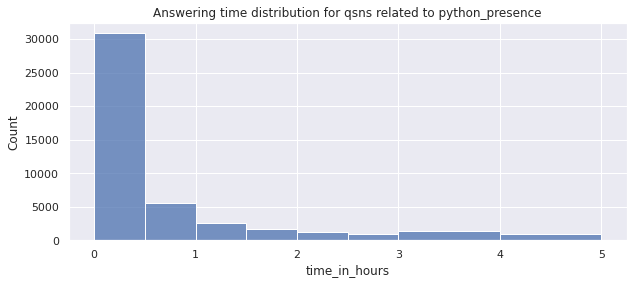

<Figure size 720x288 with 0 Axes>

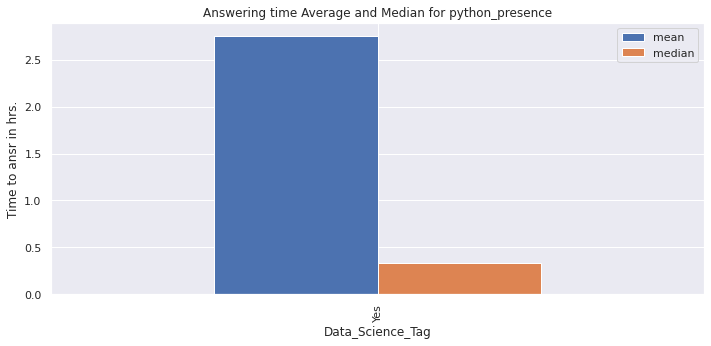

<Figure size 1800x288 with 0 Axes>

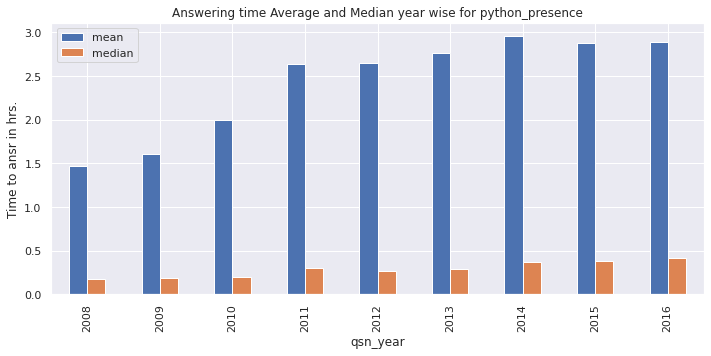

In [70]:
python_time_to_ansr=plot_charts_tag_wise(tag='python_presence')

To start with python tagged qsns, 
we can see that majority of qsns get answered in less than 0.5 hours. Community seems active :)
However, the average time for resolution came out to be between 2.5 to 3 hrs and median <  0.5 hours

Also, we tried to see if the pattern is same every year. As there is a possibility that community became aware after a specific period.
However, here we can see that time increased compared with initial 2008-2010 period. However, it seems pretty stable now since past 6 years trend year.

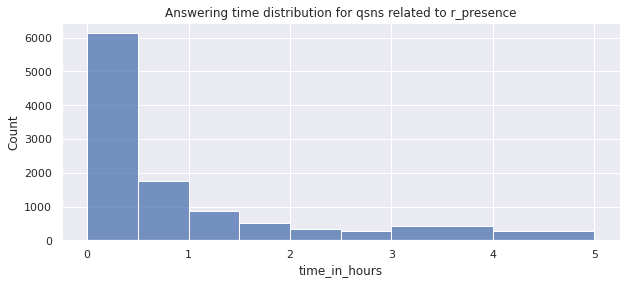

<Figure size 720x288 with 0 Axes>

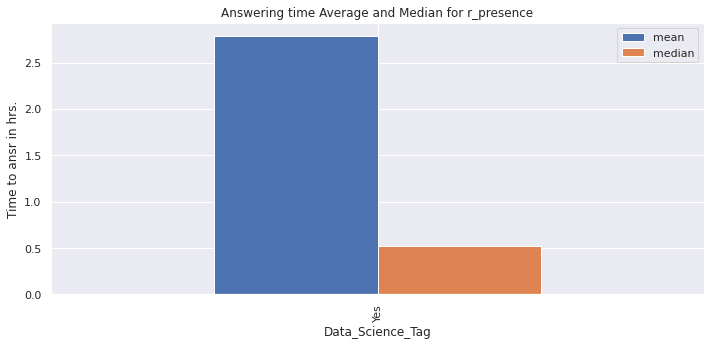

<Figure size 1800x288 with 0 Axes>

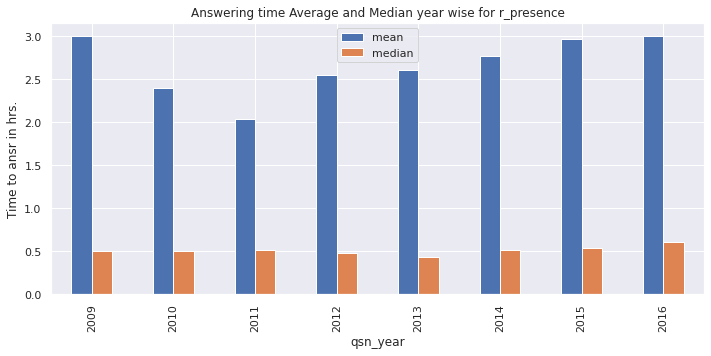

In [71]:
r_time_to_ansr=plot_charts_tag_wise(tag='r_presence')

R tagged qsns, 
we can see that majority of qsns get answered in less than 0.5 hours. Community seems active :)
However, the average time for resolution came out to be between 2.5 to 3 hrs and median <  0.5 hours

Also, we tried to see if the pattern is same every year. As there is a possibility that community became aware after a specific period.
However, it seems pretty stable now since past 2 years trend year.

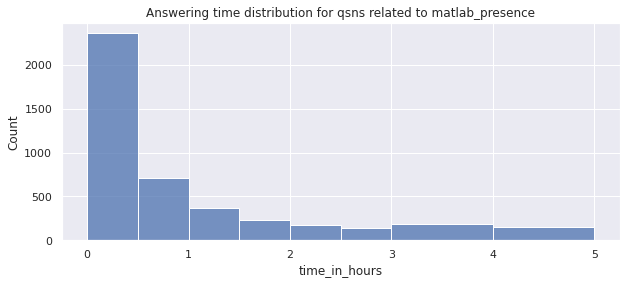

<Figure size 720x288 with 0 Axes>

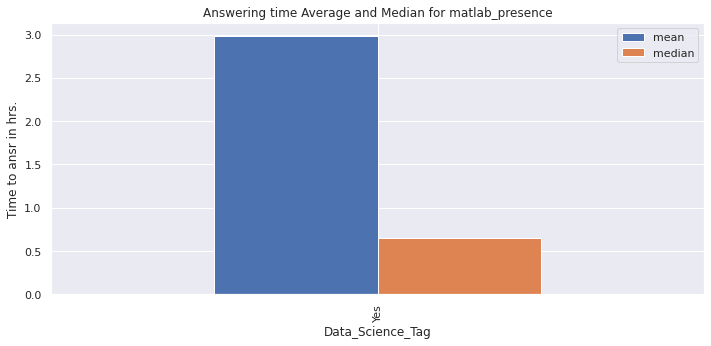

<Figure size 1800x288 with 0 Axes>

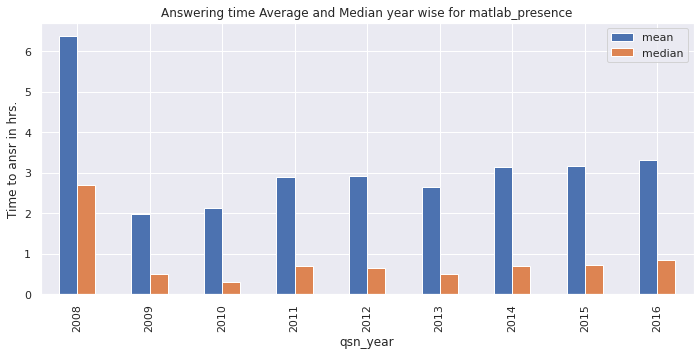

In [72]:
matlab_time_to_ansr=plot_charts_tag_wise(tag='matlab_presence')

Matlab tagged qsns, 
we can see that majority of qsns get answered in less than 1 hour. Community seems active :)
However, the average time for resolution came out to be 3hrs and median between 0.5 to 1 hours

Comaprative much time than python & r

Also, we tried to see if the pattern is same every year. As there is a possibility that community became aware after a specific period.
However, it seems pretty stable now since past 3 years trend year.

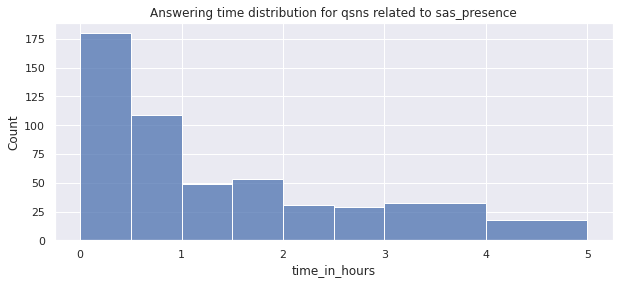

<Figure size 720x288 with 0 Axes>

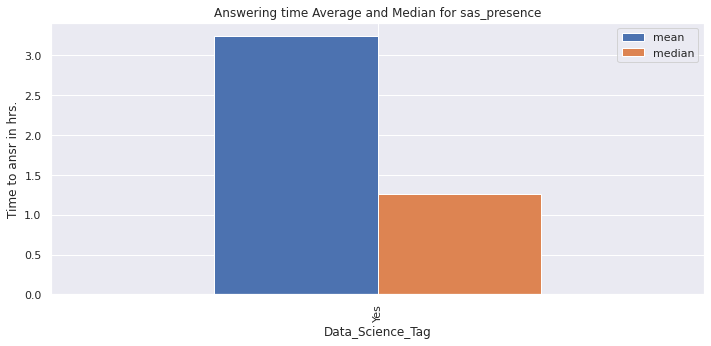

<Figure size 1800x288 with 0 Axes>

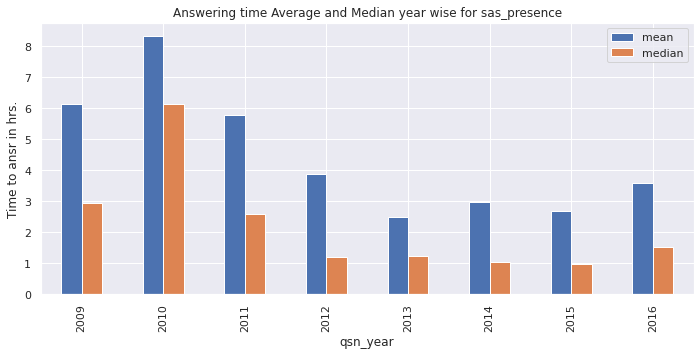

In [73]:
sas_time_to_ansr=plot_charts_tag_wise(tag='sas_presence')

SAS tagged qsns, 
we can see that majority of qsns get answered in less than 1-2 hours. Community seems active :)
However, the average time for resolution came out to be between 3-4 hrs and median between 1-1.5 hours

Comaparatively more time than answering python, r and matlab qsns

Also, we tried to see if the pattern is same every year. As there is a possibility that community became aware after a specific period.
However, here we can see that time decreases compared with initial 2008-2010 period. However, it seems pretty stable now since past 4 years trend year.

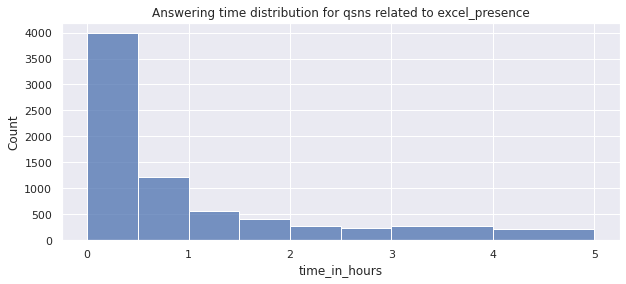

<Figure size 720x288 with 0 Axes>

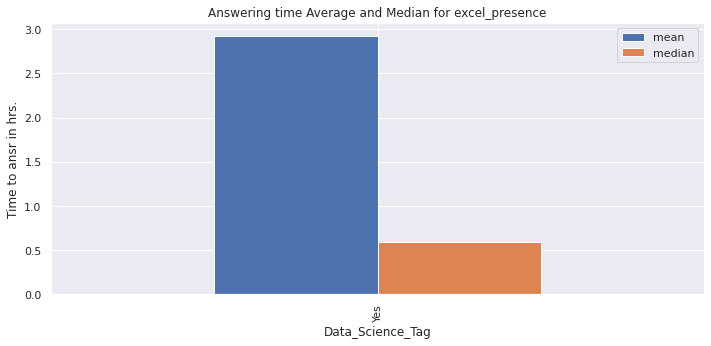

<Figure size 1800x288 with 0 Axes>

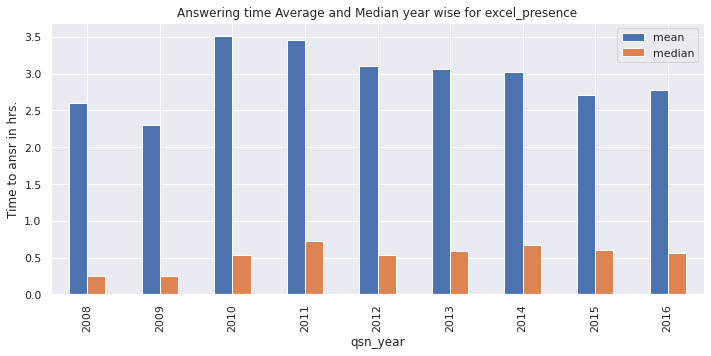

In [74]:
excel_time_to_ansr=plot_charts_tag_wise(tag='excel_presence')

Excel tagged qsns, 
we can see that majority of qsns get answered in less than 0.5-1 hours. Community seems active :)
However, the average time for resolution came out to be in between 2.5-3 hrs and median ~ 0.5 hours

Also, we tried to see if the pattern is same every year. As there is a possibility that community became aware after a specific period.
However, here we can see that time increased compared with initial 2008-2009 period. However, it seems pretty stable now since past 6 years trend year.

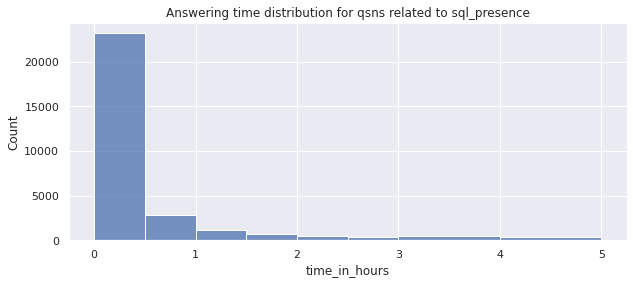

<Figure size 720x288 with 0 Axes>

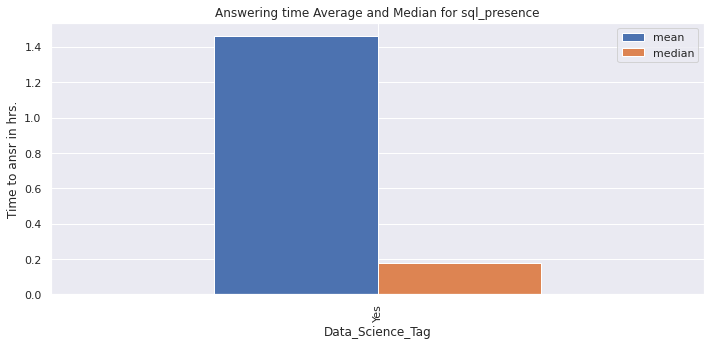

<Figure size 1800x288 with 0 Axes>

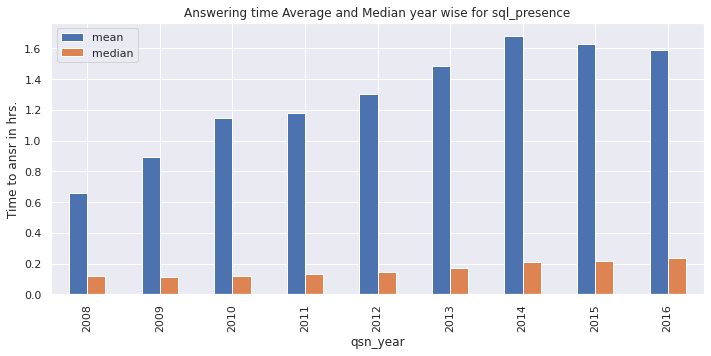

In [75]:
sql_timeto_ansr=plot_charts_tag_wise(tag='sql_presence')

SQL tagged qsns, 
we can see that majority of qsns get answered in less than 0.5 hours. Community seems active :)
However, the average time for resolution came out to be < 1.5 hrs and median <  0.2 hours.

It's resolution time is at par with python and r.

Also, we tried to see if the pattern is same every year. As there is a possibility that community became aware after a specific period.
However, here we can see that time increased compared with initial 2008-2010 period. However, it seems pretty stable now since past 3 years trend year.

For AWS we will be storing below data base for solving objective 2, as it consists of time to ansr info per tag, and with the respective tags being present on it.
So we will be inserting this data into RDS.

In [76]:
Time_to_ansr_final_data=python_time_to_ansr.append([sql_timeto_ansr, r_time_to_ansr, matlab_time_to_ansr, sas_time_to_ansr, excel_time_to_ansr])
Time_to_ansr_final_data.shape

(52, 3)

In [77]:
Time_to_ansr_final_data.head()

mean    median   Respective_Tag
qsn_year                                     
2008      1.468357  0.178750  python_presence
2009      1.611626  0.187222  python_presence
2010      1.996078  0.202500  python_presence
2011      2.639403  0.299444  python_presence
2012      2.644815  0.271944  python_presence

We can see from above, what an average or median estimate is to answer a qsn for a specific data science tag. We will ingest above data into AWS RDS for objective 2

## Objective-1

When a user raises a question with a data science tag ('python', 'r', 'matlab', 'sas', 'excel', 'sql'), then Stack Overflow sends the notification to the relevant users.


Filtering data for any Data Science Specific Tag instance

In [78]:
# Filtering data for any Data Science Specific Tag instance -- leaving only Other Tag Category out

final_data_data_science_tag_involvement=final_data[final_data['Tag_Type_grouped'].isin(['Data_Science_Tag','Data_Science_Tag,Other_Tag'])]
final_data_data_science_tag_involvement['Data_Science_Tag']='Yes'
# Filtering data for any Data Science Specific Tag instance -- leaving only Other Tag Category out



print(final_data_data_science_tag_involvement.shape,len(final_data_data_science_tag_involvement['qsn_id'].unique()))



(218761, 29) 125110


In [79]:
final_data_data_science_tag_involvement.head()

qsn_id  Qsn_by_user_id  ... user_profile_views  Data_Science_Tag
3       120            83.0  ...              105.0               Yes
135    1970           116.0  ...              549.0               Yes
136    1970           116.0  ...              534.0               Yes
137    1970           116.0  ...              221.0               Yes
138    1970           116.0  ...               34.0               Yes

[5 rows x 29 columns]

Will be recommending users to answer the qsn being tagged with a particular Data Science Tag.
* Based on their activeness in past
* Based on the scores over the ansrs they have answered in past
* Based on their reputation scores

Craeting a user recommender function
We need to provide input about what tag we are looking for and how many top users we want

In [80]:
def recommend_user(tag, top_n_users):

  data_to_use=final_data_data_science_tag_involvement[final_data_data_science_tag_involvement[tag]=='Yes']

  # Lets check how many qsns a user on an average answer

  user_ansrs_qsn_average=data_to_use[['qsn_id','user_id']].drop_duplicates().groupby(['user_id'],as_index=False).agg({'qsn_id':'count'})

  user_ansrs_qsn_average.columns=['user_id','qsns_ansr']

  print(" A user ansrs on an average " , str(round(user_ansrs_qsn_average['qsns_ansr'].mean(),0)) , " questions")

  print(" So for user recommendation we will be considering users who have answered average " , str(round(user_ansrs_qsn_average['qsns_ansr'].mean(),0))  , " no. of qsns atleast. This also proves them to be active users")
  
  user_ansrs_qsn_above_average=user_ansrs_qsn_average[user_ansrs_qsn_average['qsns_ansr'] > round(user_ansrs_qsn_average['qsns_ansr'].mean(),0)]['user_id'].unique()
  data_to_user_above_threshold_qsns_answered=data_to_use[data_to_use['user_id'].isin(user_ansrs_qsn_above_average)]
  
  data_to_use_col=data_to_user_above_threshold_qsns_answered[['user_id','user_display_name','ansr_score','user_account_creation_date','user_account_access_last_date',
                                'user_reputation','user_up_votes','user_down_votes','user_profile_views']].drop_duplicates()


  grouped_for_tag=data_to_use_col.groupby(['user_id','user_display_name','user_account_creation_date','user_account_access_last_date',
                                'user_reputation','user_up_votes','user_down_votes','user_profile_views'],as_index=False).agg({'ansr_score':'mean'})

  

  # On the basis of mean ansr score- top 5 users recommendation

  data1=grouped_for_tag.sort_values('ansr_score', ascending=False).head(top_n_users)

  plt.figure(figsize=(30, 4))
  plt.subplot(1,3,2)
  plt.title('Top users as per average ansr scores')
  sns.barplot(data=data1, y="ansr_score",x='user_display_name')
  plt.show()

  # On the basis of user reputation- top 5 users recommendation

  data2=grouped_for_tag.sort_values('user_reputation', ascending=False).head(top_n_users)

  plt.figure(figsize=(30, 4))
  plt.subplot(1,3,2)
  plt.title('Top users as per reputation scores')
  sns.barplot(data=data2, y="user_reputation",x='user_display_name')
  plt.show()


  # Data Preparation that needs to be ingested in AWS RDS- We will be inserting per tag, top 5 users as per ansr score and reputation
  data1['Tag']=tag
  data1['Ansr_Score']='Ansr_Score'

  data2['Tag']=tag
  data2['Reputation_Score']='Ansr_Score'

  data_final=data1.append([data2])
  return data_final


  

Call function for different data science tags (python, r, matlab, sas, excel, sql) and get the top recommended users based on their activeness, reputation score and ansr scores

 A user ansrs on an average  3.0  questions
 So for user recommendation we will be considering users who have answered average  3.0  no. of qsns atleast. This also proves them to be active users


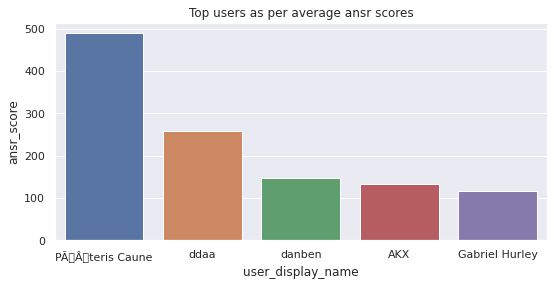

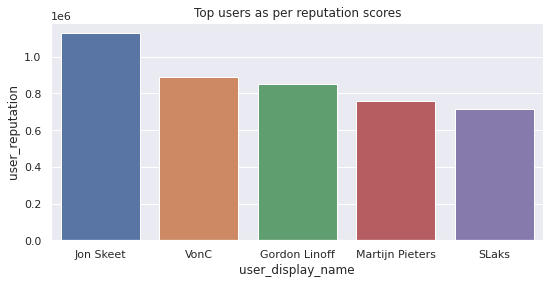

In [81]:
data_python=recommend_user(tag='python_presence',top_n_users=5)

 A user ansrs on an average  4.0  questions
 So for user recommendation we will be considering users who have answered average  4.0  no. of qsns atleast. This also proves them to be active users


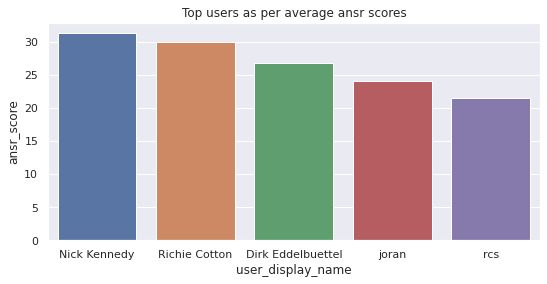

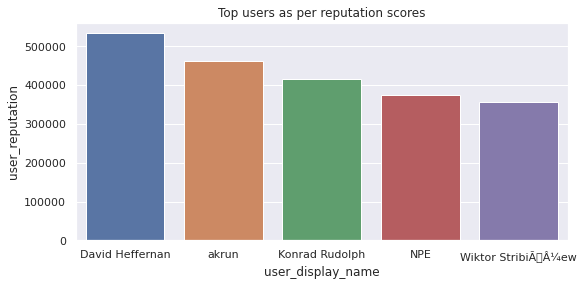

In [82]:
data_r=recommend_user(tag='r_presence',top_n_users=5)

 A user ansrs on an average  3.0  questions
 So for user recommendation we will be considering users who have answered average  3.0  no. of qsns atleast. This also proves them to be active users


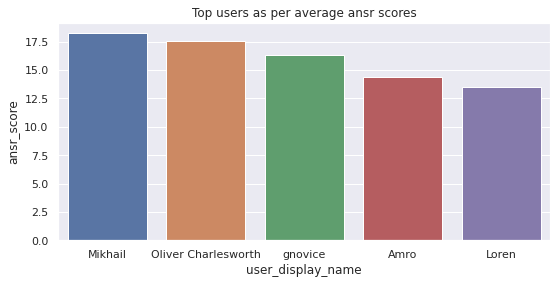

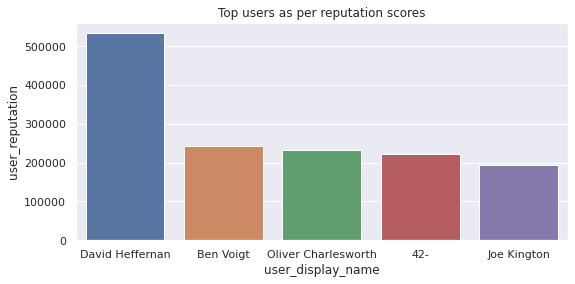

In [83]:
data_matlab=recommend_user(tag='matlab_presence',top_n_users=5)

 A user ansrs on an average  3.0  questions
 So for user recommendation we will be considering users who have answered average  3.0  no. of qsns atleast. This also proves them to be active users


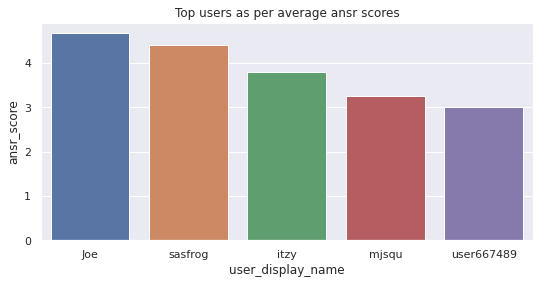

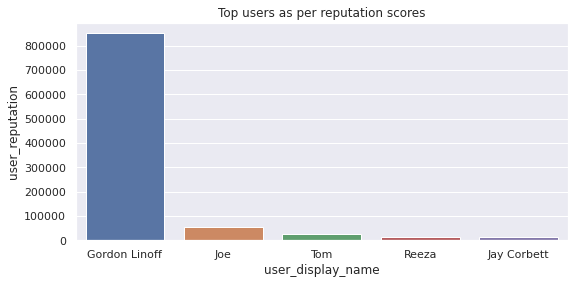

In [84]:
data_sas=recommend_user(tag='sas_presence',top_n_users=5)

 A user ansrs on an average  2.0  questions
 So for user recommendation we will be considering users who have answered average  2.0  no. of qsns atleast. This also proves them to be active users


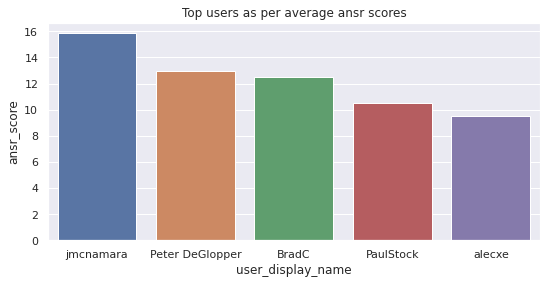

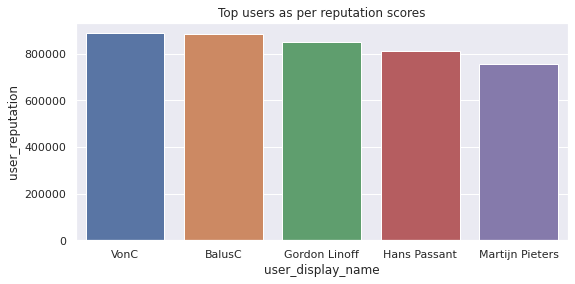

In [85]:
data_excel=recommend_user(tag='excel_presence',top_n_users=5)

 A user ansrs on an average  2.0  questions
 So for user recommendation we will be considering users who have answered average  2.0  no. of qsns atleast. This also proves them to be active users


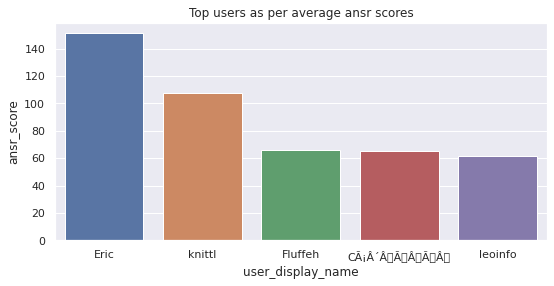

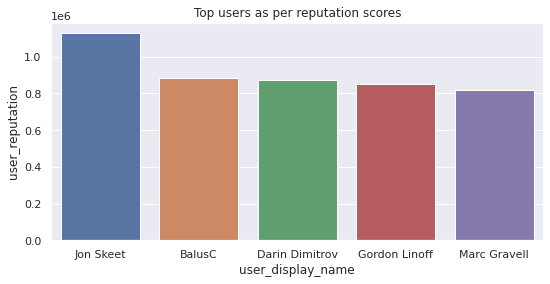

In [86]:
data_sql=recommend_user(tag='sql_presence',top_n_users=5)

The below data when filetered for a particular tag using column Tag and using Ansr_Score & Reputation_Score will give top 5 users recommendation

In [87]:
data_all_6_tags_user_recommendation=data_python.append([data_r, data_excel, data_sql, data_matlab, data_sas])

data_all_6_tags_user_recommendation.shape

(60, 12)

In [88]:
data_all_6_tags_user_recommendation.head()

user_id user_display_name  ...  Ansr_Score Reputation_Score
66     5821.0  PÃÂteris Caune  ...  Ansr_Score              NaN
125   11549.0              ddaa  ...  Ansr_Score              NaN
910  217332.0            danben  ...  Ansr_Score              NaN
354   51685.0               AKX  ...  Ansr_Score              NaN
579  114672.0    Gabriel Hurley  ...  Ansr_Score              NaN

[5 rows x 12 columns]

Will be dumping the above data into AWS RDS for Objective 1

## Objective-3

While a user raises a question, Stack Overflow wants to provide some suggestions to the users to get their queries answered quickly.

### Now building a qsn recommender engine using the below user inputs-
* Input qsn 
* Corresponding tag name
* how many top qsns we want to see correspondingly

Already we have provided users recommendation for best resolving of the query, now we need to provide suggestions to the users for their best qsn resolution. Will provide the top similar qsns from the same Data Science Tag tagged category as recommendation to go through their answers.


We can also use cosine similarity score to find out the questions that are most similar to the one that user posted

In [89]:

WORD = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)



In [90]:
def qsns_recommendation_based_on_similarity_score(qsn_title, tag, topn):
   
  # lower casing everything

  text1 = qsn_title.lower()

  qsn_title_data = final_data_data_science_tag_involvement[(~final_data_data_science_tag_involvement['qsn_title'].isnull()) &
                                                          (final_data_data_science_tag_involvement[tag]=='Yes')][['qsn_title']].drop_duplicates()
    
  similarity_score=[]

  for i in qsn_title_data['qsn_title'].str.lower():
    text2 = i

    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)

    cosine = get_cosine(vector1, vector2)

    similarity_score.append(cosine)

  qsn_title_data['similarity_score']= similarity_score
  data=qsn_title_data.sort_values('similarity_score',ascending=False).head(topn)

  print('Top ' , topn, ' similar qsns whose answers users can look upon to resolve their queries themselves \n')
  
  for i in data['qsn_title']:
    print(i , "--> A similarity score of ", data[data['qsn_title']==i]['similarity_score'].values)


  plt.figure(figsize=(30, 4))
  plt.title('Top similar qsns')
  sns.barplot(data=data, y="similarity_score",x='qsn_title')
  plt.show()
  
  # We can keep separate the data which will have resulting similar qsns with their answers for user ease
  data=final_data_data_science_tag_involvement[final_data_data_science_tag_involvement['qsn_title'].isin(list(data['qsn_title'].unique()))]
  return data
    



Python tag similar qsns recommendation

Top  5  similar qsns whose answers users can look upon to resolve their queries themselves 

SAS Proc SQL Database Table Insert --> A similarity score of  [0.81649658]
How to change data layout in SAS (possible PROC SQL)? --> A similarity score of  [0.52704628]
Using PROC SQL in SAS to transpose a table from long to wide --> A similarity score of  [0.51639778]
how to create customized frequency table in SAS --> A similarity score of  [0.47140452]
How to use SAS code to make a table like this? --> A similarity score of  [0.46225016]


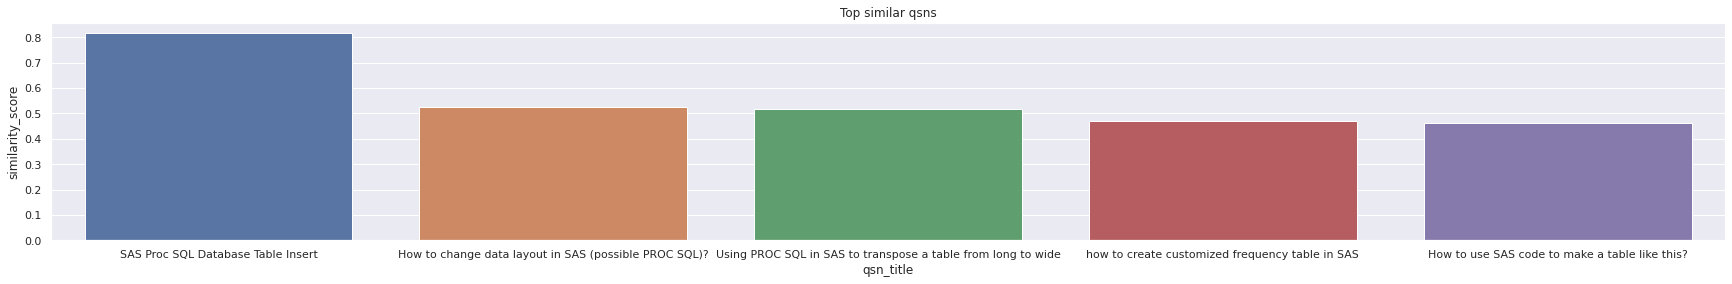

In [91]:
# Call the function - just provide three inputs, your qsn, tag type of qsn and how many top recommended qsns you want to see

python_data_peak=qsns_recommendation_based_on_similarity_score(qsn_title='how to perform SAS Proc SQL Database Table Insert', tag='sas_presence', topn=5)

In [92]:
# If we want we can see the answers to the above recommended qsns from below
# A qsn will be having multiple answers to it. It will help users to look into the ansrs
python_data_peak[['qsn_title','ansr_body']].head()

qsn_title                                          ansr_body
69597                   SAS Proc SQL Database Table Insert  <p>To my knowledge, using pass through SQL con...
69598                   SAS Proc SQL Database Table Insert  <p>You can do what you want within an open con...
1159900  How to change data layout in SAS (possible PRO...  <p>You need to aggregate the VALUE column befo...
1159901  How to change data layout in SAS (possible PRO...  <p>It seems like you need to sum the VALUEs to...
1463292     How to use SAS code to make a table like this?  <p>You can enter data into SAS like this</p>\n...

Excel tag recommended similar qsns

Top  5  similar qsns whose answers users can look upon to resolve their queries themselves 

Best solution for using EJBs from Excel --> A similarity score of  [0.9258201]
Copy from Excel using C# --> A similarity score of  [0.54772256]
Run Excel Macro from Outside Excel Using VBScript From Command Line --> A similarity score of  [0.52704628]
Search for email subject in outlook from excel using vba? --> A similarity score of  [0.51639778]
Open Excel from Word using FileDialog --> A similarity score of  [0.5]


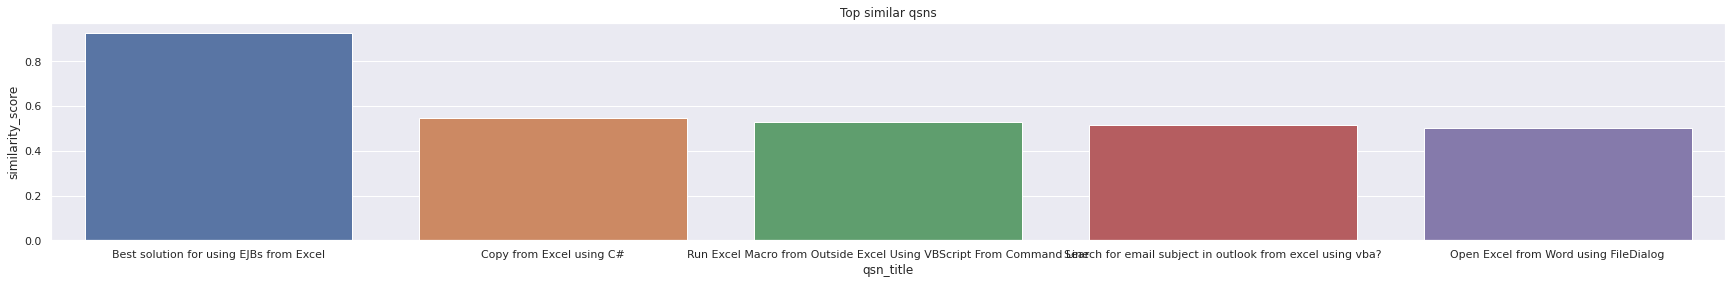

In [93]:
# Call the function - just provide three inputs, your qsn, tag type of qsn and how many top recommended qsns you want to see

excel_data_peak=qsns_recommendation_based_on_similarity_score(qsn_title='Solution for using EJBs from Excel', tag='excel_presence', topn=5)

In [94]:
# If we want we can see the answers to the above recommended qsns from below
# A qsn will be having multiple answers to it. It will help users to look into the ansrs

excel_data_peak[['qsn_title','ansr_body']].head()

qsn_title                                          ansr_body
5785  Best solution for using EJBs from Excel  <p>You could take a look at <a href="http://ww...
5786  Best solution for using EJBs from Excel  <p>If you have a fairly recent ejb container, ...
5787  Best solution for using EJBs from Excel  <p>Back in the VB6/COM/DCOM times we used the ...
5788  Best solution for using EJBs from Excel  <p>I highly recommend <a href="http://www.ikvm...
5789  Best solution for using EJBs from Excel  <p>I work on an open source project called <a ...

SQL tagged similar qsns recommendation

In [95]:
|# Call the function - just provide three inputs, your qsn, tag type of qsn and how many top recommended qsns you want to see

sql_data_peak=qsns_recommendation_based_on_similarity_score(qsn_title='Explain multiple foreign keys?', tag='sql_presence', topn=5)

SyntaxError: ignored

In [ ]:
# If we want we can see the answers to the above recommended qsns from below
# A qsn will be having multiple answers to it. It will help users to look into the ansrs
sql_data_peak[['qsn_title','ansr_body']].head()

Matlab tagged similar qsns recommendation

Top  5  similar qsns whose answers users can look upon to resolve their queries themselves 

What alternatives are there to the MATLAB Editor? --> A similarity score of  [0.63960215]
Why the fourier spectra concentrated to the border of the image (in Matlab)? --> A similarity score of  [0.55337157]
Matlab: how to get the commandline to the new 2013 UI? --> A similarity score of  [0.54494926]
To insert the images as the element of the matrix --> A similarity score of  [0.52764485]
How can I change the behavior of the commenting function so that the location of the % respect the indentation? --> A similarity score of  [0.51796977]


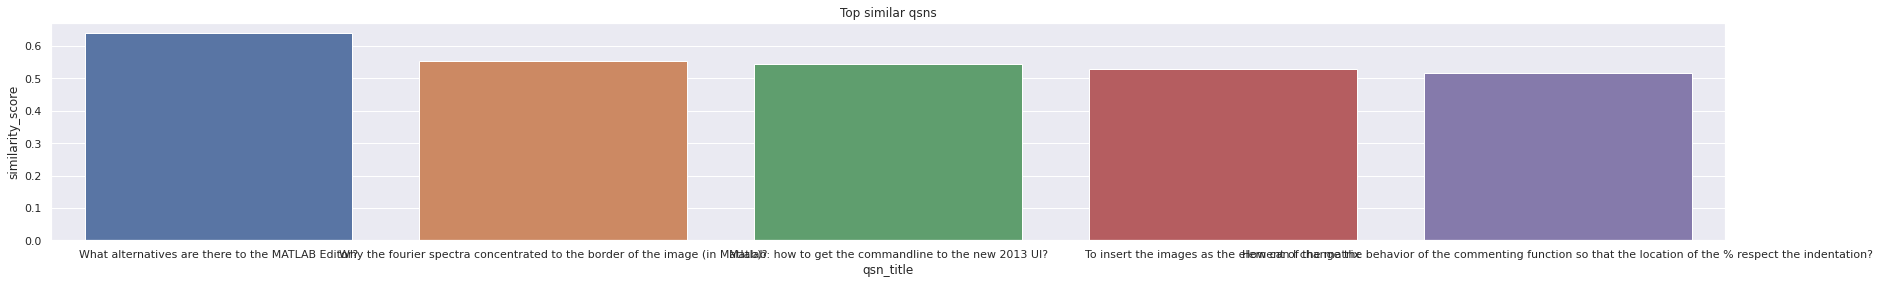

In [96]:
# Call the function - just provide three inputs, your qsn, tag type of qsn and how many top recommended qsns you want to see

matlab_data_peak=qsns_recommendation_based_on_similarity_score(qsn_title='May I know the alternatives to the MATLAB Editor?', tag='matlab_presence', topn=5)

In [97]:
# If we want we can see the answers to the above recommended qsns from below
# A qsn will be having multiple answers to it. It will help users to look into the ansrs
matlab_data_peak[['qsn_title','ansr_body']].head()

qsn_title                                          ansr_body
5331  What alternatives are there to the MATLAB Editor?  <p>I use emacs for MATLAB stuff, but then I us...
5332  What alternatives are there to the MATLAB Editor?  <p>You can use any editor you like in MATLAB b...
5333  What alternatives are there to the MATLAB Editor?  <p>There's also a <a href="http://macromates.c...
5334  What alternatives are there to the MATLAB Editor?  <p>Eclipse with the Colorer plugin has decent ...
5335  What alternatives are there to the MATLAB Editor?  <p>I might be biased, but I use emacs for almo...

R tagged similar qsns recommendation

Top  5  similar qsns whose answers users can look upon to resolve their queries themselves 

How to reduce size of R plots in EPS format? --> A similarity score of  [0.83666003]
R: how to add points to multiple plots using apply? --> A similarity score of  [0.54554473]
How to using dlply to apply breakpoints function of package strucchange to subsets of data ?[R] --> A similarity score of  [0.54006172]
How to reduce the size of the legend in R Plot, while still making it readable? --> A similarity score of  [0.53452248]
R how to identify distance of last occurance --> A similarity score of  [0.53452248]


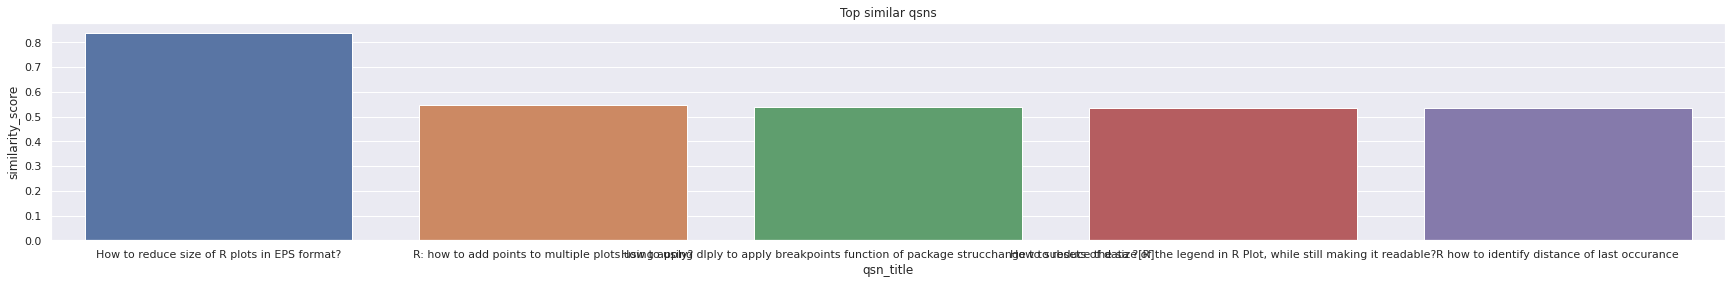

In [98]:
# Call the function - just provide three inputs, your qsn, tag type of qsn and how many top recommended qsns you want to see

r_data_peak=qsns_recommendation_based_on_similarity_score(qsn_title='How to reduce size of R plots ', tag='r_presence', topn=5)

In [99]:
# If we want we can see the answers to the above recommended qsns from below
# A qsn will be having multiple answers to it. It will help users to look into the ansrs
r_data_peak[['qsn_title','ansr_body']].head()

qsn_title                                          ansr_body
78152  How to reduce size of R plots in EPS format?  <p>Well, EPS just contains instructions to dra...
78153  How to reduce size of R plots in EPS format?  <p>You have three options.</p>\n\n<ol>\n<li>Ac...
78154  How to reduce size of R plots in EPS format?  <p>I've just tried several things that didn't ...
78155  How to reduce size of R plots in EPS format?  <p>In this discussion at the R-list <a href="h...
78156  How to reduce size of R plots in EPS format?  <p>in GS view, convert our files to pdf, then ...

For above approach, we need to just insert the complete list of qsn titles along with its answers or scores, so that above recommendation function can look for similar qsns in that data set on basis of user provided qsn.

So, if we want we can ingest that data into AWS RDS. However, that itself will not be having any intelligence as above function will run over it and will provide similar suggestions.

### Till now we provided similar qsns already in the system to look for answers, users can look for their corresponding answers. 
Now just for reference, users can also see the top scored qsns in respect to the data science tag categories

In [100]:
# Now we will see how to give popular qsns suggestions from the same tag so that user can get required ansrs from there if fits

def qsn_recommendation(tag,topn_qns):
    data_to_use=final_data_data_science_tag_involvement[final_data_data_science_tag_involvement[tag]=='Yes']
    
    # simply recommending qsns based on the top score qsns present in that tag category
    top_qsns=list(data_to_use[['qsn_title','qsn_score']].drop_duplicates().sort_values('qsn_score', ascending=False).head(topn_qns)['qsn_title'].unique())

    print('User can see answers to the top/ popular qns')
   
    for i in top_qsns:
      print(i)
    
    # Praparing data to be ingested in AWS RDS for objective 3

    data=data_to_use[data_to_use['qsn_title'].isin(top_qsns)]
    data['Respective_Tag']= tag

    return data


In [101]:
python_top_qsns=qsn_recommendation(tag='python_presence',topn_qns=5)

User can see answers to the top/ popular qns
Quick and easy: trayicon with python?
Using Python's list index() method on a list of tuples or objects?
What are Python dictionary view objects?
generating variable names on fly in python
Multiple Models in a single django ModelForm?


In [102]:
matlab_top_qsns=qsn_recommendation(tag='matlab_presence',topn_qns=5)

User can see answers to the top/ popular qns
What alternatives are there to the MATLAB Editor?
How to document object-oriented MATLAB code?
How can I generate a list of function dependencies in MATLAB?
Accelerating MATLAB code using GPUs?
Using i and j as variables in Matlab


In [103]:
r_top_qsns=qsn_recommendation(tag='r_presence',topn_qns=5)

User can see answers to the top/ popular qns
Handling missing/incomplete data in R--is there function to mask but not remove NAs?
Compile R script into standalone .exe file?
How can a test script inform R CMD check that it should emit a custom message?
Why is running "unique" faster on a data frame than a matrix in R?
Email an attachment in R with gmail


In [104]:
excel_top_qsns=qsn_recommendation(tag='excel_presence',topn_qns=5)

User can see answers to the top/ popular qns
How to reference Microsoft.Office.Interop.Excel dll?
Convert xlsx to csv in linux command line
How should I escape commas and speech marks in CSV files so they work in Excel?
How to "flatten" or "collapse" a 2D Excel table into 1D?
How can I lock the first row and first column of a table when scrolling, possibly using JavaScript and CSS?


In [105]:
sas_top_qsns=qsn_recommendation(tag='sas_presence',topn_qns=5)

User can see answers to the top/ popular qns
Experience with using h5py to do analytical work on big data in Python?
sas date - convert today() into yyyymmdd format
SAS memory usage and sorting
Efficiently convert a SAS dataset into a CSV
Sorting an almost sorted dataset in SAS


In [106]:
sql_top_qsns=qsn_recommendation(tag='sql_presence',topn_qns=5)

User can see answers to the top/ popular qns
OVER clause in Oracle
Combination of 'LIKE' and 'IN' using t-sql
How to retrieve field names from temporary table (SQL Server 2008)
Using GROUP_CONCAT on subquery in MySQL
How to implement a Keyword Search in MySQL?


Will be ingesting this data into AWS RDS for top 5 popular qsns with answers wrt every data science tag

In [107]:
final_qsn_data=python_top_qsns.append([sql_top_qsns, excel_top_qsns, matlab_top_qsns, r_top_qsns, sas_top_qsns])
final_qsn_data.shape

(148, 30)

### Also, will be providing certain insights like whether too many no. of tags helps in faster resolution of question or not 

In [108]:
final_data_data_science_tag_involvement=pd.merge(final_data_data_science_tag_involvement,Time_to_ansr[['qsn_id','time_in_hours']].drop_duplicates(),on='qsn_id',how='left')

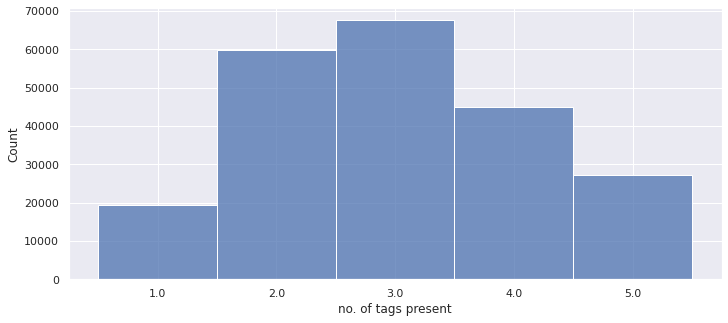

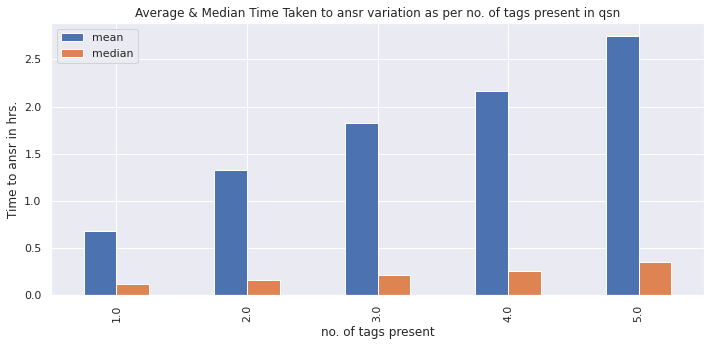

In [109]:
final_data_data_science_tag_involvement['no. of tags present']=final_data_data_science_tag_involvement['no. of tags present'].astype(str)
sns.histplot(data=final_data_data_science_tag_involvement.sort_values('no. of tags present'), x="no. of tags present")
plt.show()

final_data_data_science_tag_involvement.groupby('no. of tags present')['time_in_hours'].agg(['mean','median']).plot.bar();
plt.title('Average & Median Time Taken to ansr variation as per no. of tags present in qsn')
plt.ylabel('Time to ansr in hrs.')
plt.show()



From above, we can see that majority of the questions are present with 2 or 3 tags on them.
However, it doesn't help in faster resoltion, a qsn correctly mapped with one tag, showing the exact issue, helps in proper directing of qsn and people ansrs them fastly.

## New Objective:
 Let’s say Stack Overflow also wants to post some details on its job website to help various employees understand the subjects or topics trending in the industry.

### We can provide the popular tags which will give idea to users in the sense like where user participation is most active

In [110]:

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.title('Whats happening & popular in world of language & tools??')
    plt.show()


Among Data Science tags, users can see from below, the trending language in motion. 
As seen Javascript community is on fire in that interval.
The above word cloud gives an idea over what's new in market and the size indicates the community size

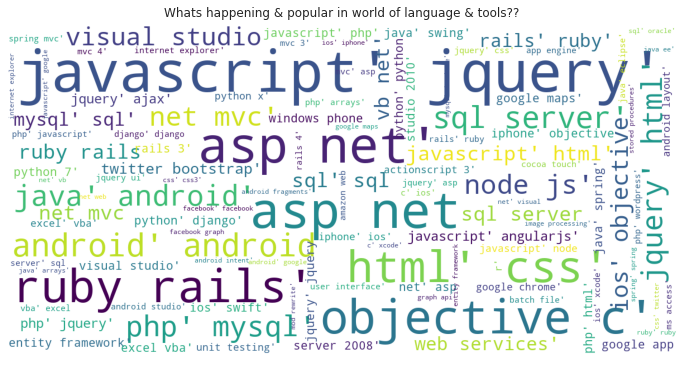

In [111]:
show_wordcloud(list(tags['Tag']))

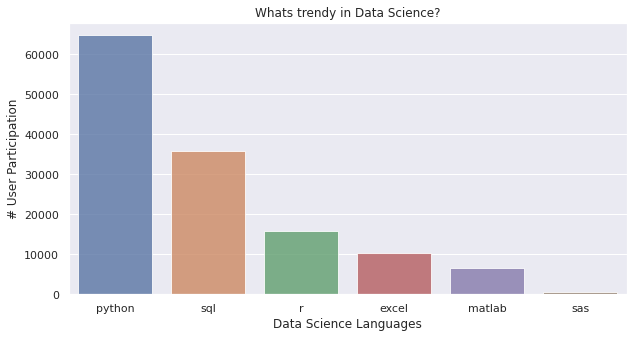

In [112]:
datascience_tags_count  = tags[tags['Data_Science_Tag_or_Other']=='Data_Science_Tag']['Tag'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(datascience_tags_count.index, datascience_tags_count.values, alpha=0.8)
plt.title('Whats trendy in Data Science?')
plt.ylabel('# User Participation')
plt.xlabel('Data Science Languages')
plt.show()

From above, we can see that wrt. data science community, we have active participation in python than sql than r....and list goes on.

### We can also see the evolution of data science language community from below year on year trend.
It will help us understand the shift which is happening in industry

Python Evolution

In [113]:
def evolution_of_language(tag):
  # print(Time_to_ansr.shape)
  data= Time_to_ansr[Time_to_ansr[tag]=='Yes']
  # print(data.shape)
  data1=data.groupby(['qsn_year'],as_index=False).agg({'qsn_id':'count'})
  data1.columns=['qsn_year','participation']
  sns.lineplot(x="qsn_year", y="participation", data=data1) 
  plt.title('Evolution of language')
  plt.show()

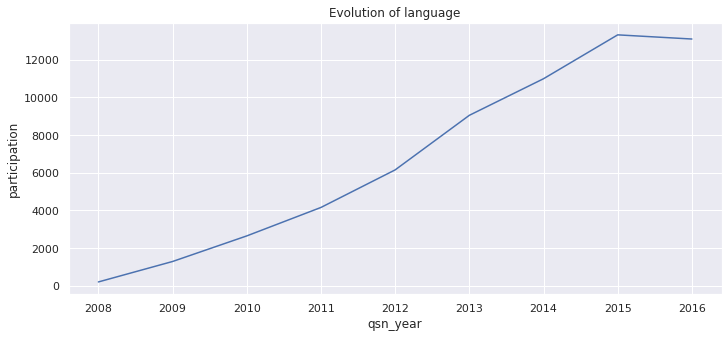

In [114]:
evolution_of_language('python_presence')

We can see that from 2008, python community has came a long way..
However it got kind of stable in 2015 - 2016 (kinda declined ways)
But this has highest user base among remaing data science tags.

R evolution

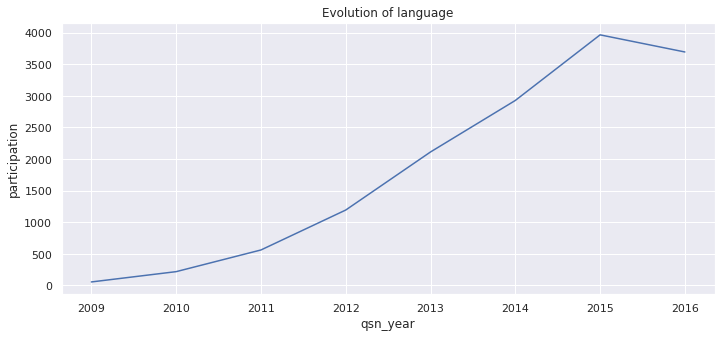

In [115]:
evolution_of_language('r_presence')

We can see that from 2009, r community has came a long way..
However it got kind of declined in 2015 - 2016.
It's becuase at that time, python took over and BOOM!! People shifted to python!

Matlab Evolution

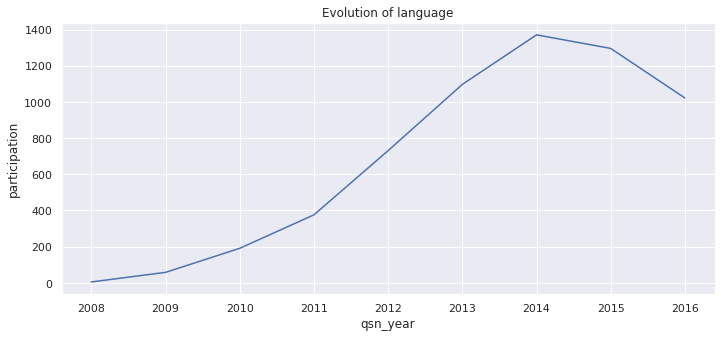

In [116]:
evolution_of_language('matlab_presence')

We can see that from 2008, matlab community has came a long way..
However there's a fall after 2014. 
Doesn't seem people wish to continue using it and may be shifting to other languages (easy ones!)

SQL Evolution

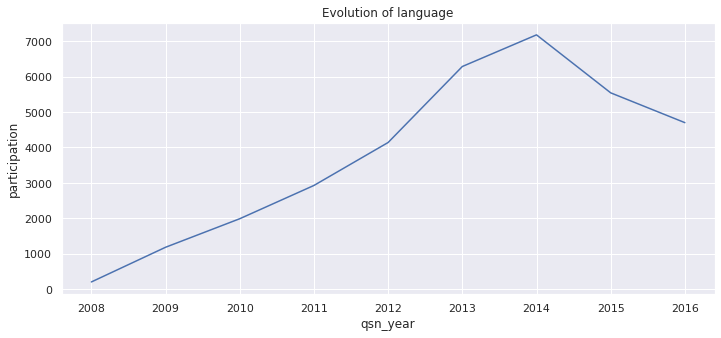

In [117]:
evolution_of_language('sql_presence')

We can see that from 2008, sql community has came a long way..
However there's a fall after 2014.
People seems not interested in it that much now.

SAS Evolution

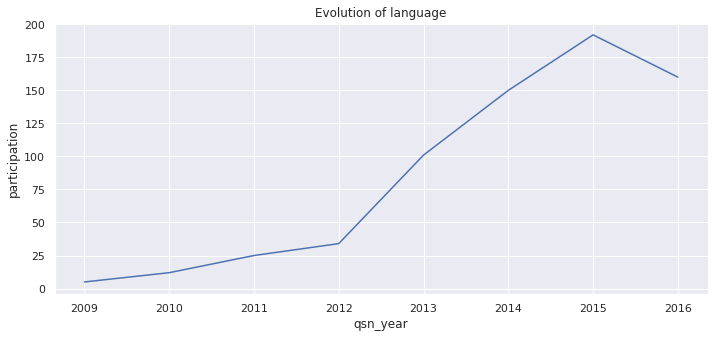

In [118]:
evolution_of_language('sas_presence')

We can see that from 2009, SAS community has came a long way..Its start was not that smooth but it picked up momentum in 2012, 
However, after 2015, there's a fall.
Industries are moving to python, may be a reason.

But this has highest user base among remaing data science tags.

Excel Evolution

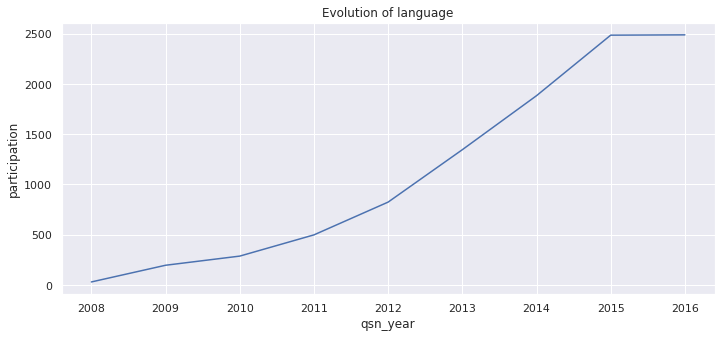

In [119]:
evolution_of_language('excel_presence')

We can see that from 2008, Excel community has came a long way..
However it got kind of stable in 2015 - 2016.
Excel is ever green and used by every industry. SO it's not weird to see this trend. :)

End of Assignment! Feedback awaited!

Summary:
* Did basic EDA
* Standardized data sets
* Brought them on same page
* Addressed asked objective